<a href="https://colab.research.google.com/github/aiarabelo/LaCoO3_Thermodynamics/blob/main/Thermodynamic_Model_for_LaCoO3_(LCO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import linregress
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import savgol_filter
import matplotlib.colors as mcolors

In [2]:
colors = ['crimson', 'teal', 'purple', 'magenta', 'forestgreen', 'orange','darkkhaki', 'palevioletred', 'saddlebrown', 'blue', 'violet', 'firebrick', 'coral', 'steelblue']

In [3]:
# Constants
kb_ev = 8.617e-5 # eV/K
kb_cm = 0.695034800 # cm-1/K
eps0 = [0,0,0]
eps = [-30.69, -31.18, -46.04]
energies = np.array([13, 35.5, 72.5]) * 1e-3 # eV

# Model for the spin crossover of LCO

In [4]:
class SpinCrossoverPartitionFunction:
    def __init__(self):
        self.energies = np.array([13, 35.5, 72.5]) * 1e-3  # Convert from meV to eV
        self.degeneracies = np.array([3, 5, 7])

    def get_Z(self, T, eps=[0,0,0], noise_factor=None, LS_noise=[0,0,0], HS_noise=[0,0,0]):
        n_init = self.get_n(T, eps=eps,noise_factor=noise_factor, LS_noise=LS_noise, HS_noise=HS_noise).n
        beta = 1/(kb_ev*T)
        LS_noise1, LS_noise2, LS_noise3 = LS_noise
        HS_noise1, HS_noise2, HS_noise3 = HS_noise
        eps = np.array(eps)*kb_ev/kb_cm
        E1,E2,E3 = self.energies
        eps1,eps2,eps3 = eps
        self.LS = (np.exp(-beta*(LS_noise1+eps1*n_init**2))) + np.exp(-beta*(LS_noise2+eps2*n_init**2)) + np.exp(-beta*(LS_noise3+eps3*n_init**2))
        self.HS = (3*np.exp(-beta*(HS_noise1+E1-2*eps1*n_init)) + 5*np.exp(-beta*(HS_noise2+E2-2*eps2*n_init)) + 7*np.exp(-beta*(HS_noise3+E3-2*eps3*n_init)))
        self.total = self.HS + self.LS
        return self

    def get_n(self, T, eps, noise_factor=None, tol = 1e-5, LS_noise=[0,0,0], HS_noise=[0,0,0]):
        beta = 1/(kb_ev*T)
        eps = np.array(eps)*kb_ev/kb_cm
        E1,E2,E3 = self.energies
        eps1,eps2,eps3 = eps
        iter_diff = 50
        i = 0
        LS_noise1, LS_noise2, LS_noise3 = LS_noise
        HS_noise1, HS_noise2, HS_noise3 = HS_noise
        if T >= 100:
          n_init = 0.01
        else:
          n_init = 0.01

        result = n_init
        while ((iter_diff) > tol) or (i < 10):
          i+=1
          try:
            ZHS = (3*np.exp(-beta*(E1-2*eps1*n_init+HS_noise1)) + 5*np.exp(-beta*(E2-2*eps2*n_init+HS_noise2)) + 7*np.exp(-beta*(E3-2*eps3*n_init+HS_noise3)))
            ZLS =   ((np.exp(-beta*(LS_noise1+eps1*n_init**2)) + np.exp(-beta*(LS_noise2+eps2*n_init**2))) + np.exp(-beta*(LS_noise3+eps3*n_init**2)))
            result = (1 + (ZLS)/ZHS)**-1
          except:
            n_init = np.random.rand()
            print('Attempt', i)
          iter_diff = np.abs(result-n_init)
          if (result < 0) or (result >= 1):
            n_init = np.random.rand()
            iter_diff = 50
            if i > 15:
              break
          else:
            self.n = result
            return self
        self.n = result
        return self

    def get_E(self, T, eps, noise_factor=None, LS_noise=[0,0,0], HS_noise=[0,0,0]):
        Z = self.get_Z(T, eps, noise_factor, LS_noise, HS_noise)
        self.total = -kb_ev*T*np.log(Z.total)
        self.HS = -kb_ev*T*np.log(Z.HS)
        self.LS = -kb_ev*T*np.log(Z.LS)
        return self #

scpf = SpinCrossoverPartitionFunction()

In [5]:
def thermal_energy(temperature, num_samples, noise_factor=None):
    beta = 1 / (kb_ev * temperature)
    thermal_energy = kb_ev * temperature
    if num_samples == 1:
      noisy_energy =  np.random.normal(0, thermal_energy)
    else:
      noisy_energy =  np.random.normal(0, thermal_energy, num_samples)
    return noisy_energy

In [6]:
def calc_ea(T,incr=1,kb=kb_ev, get_slopes=False, noise=0, version = 'v1',eps=None):
  keq = np.array([])
  temps = np.linspace(T-incr, T+incr,5)
  for temp in temps:
    if version == 'v1':
      hsf = scpf.get_n(temp,eps,noise).n
    lsf = 1-hsf
    keq_ = hsf/lsf
    keq = np.append(keq,keq_)
  x = 1/temps
  y = np.log(keq)
  slope= linregress(x,y).slope
  intercept = linregress(x,y).intercept
  ea = slope*-kb # eV
  if get_slopes == True:
    return ea, slope, intercept
  else:
    return ea

# Material properties

In [17]:
temps = np.linspace(5,700, 150)
reference_nhs = np.array([scpf.get_n(temp, eps=eps).n for temp in temps])
reference_nhs0 = np.array([scpf.get_n(temp, eps=eps0).n for temp in temps])

## Spin population

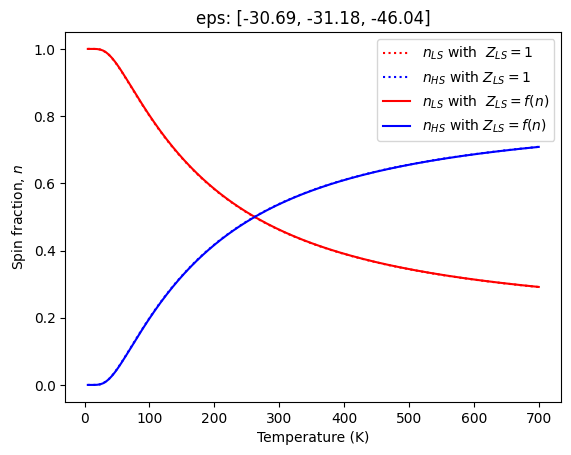

In [19]:
plt.figure()
plt.plot(temps, 1 - reference_nhs0,linestyle='dotted', label = '$n_{LS}$ with  $Z_{LS} = 1$', color = 'red')
plt.plot(temps, reference_nhs0,linestyle='dotted', label = '$n_{HS}$ with $Z_{LS} = 1$', color='blue')
reference_nhs = np.array([scpf.get_n(temp, eps=eps).n for temp in temps])
plt.plot(temps, 1 - reference_nhs, label = '$n_{LS}$ with  $Z_{LS} = f(n)$', color = 'red')
plt.plot(temps, reference_nhs, label = '$n_{HS}$ with $Z_{LS} = f(n)$', color = 'blue')
plt.title(f'eps: {eps}')
plt.xlabel('Temperature (K)')
plt.ylabel('Spin fraction, $n$')
plt.legend()

<ipython-input-4-482195b3696a>:38: RuntimeWarning: overflow encountered in exp
  ZLS =   ((np.exp(-beta*(LS_noise1+eps1*n_init**2)) + np.exp(-beta*(LS_noise2+eps2*n_init**2))) + np.exp(-beta*(LS_noise3+eps3*n_init**2)))
<ipython-input-4-482195b3696a>:37: RuntimeWarning: overflow encountered in exp
  ZHS = (3*np.exp(-beta*(E1-2*eps1*n_init+HS_noise1)) + 5*np.exp(-beta*(E2-2*eps2*n_init+HS_noise2)) + 7*np.exp(-beta*(E3-2*eps3*n_init+HS_noise3)))
<ipython-input-4-482195b3696a>:39: RuntimeWarning: overflow encountered in scalar divide
  result = (1 + (ZLS)/ZHS)**-1


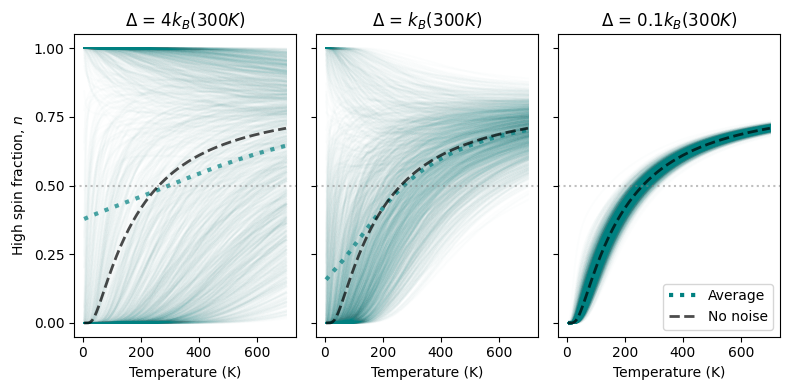

In [35]:
n_mags = {}
n_mags_ = []
yticks = [0, 0.25, 0.5, 0.75, 1.0]
num_samples = 1500
mags = [0.25,1,10]
test_eps = [-30.69, -31.18, -46.04]
fig, axs = plt.subplots(1,3, figsize=(8,4), sharey='all')
for k,mag in enumerate(mags):
  temp_ = 300
  for i in range(num_samples):
    noise_samples = thermal_energy(temp_, 6, noise_factor=1)/mag
    HS_noise = noise_samples[:3]
    LS_noise = noise_samples[3:]
    n_noised = np.array([scpf.get_n(temp,eps=test_eps,LS_noise=LS_noise, HS_noise=HS_noise).n for temp in temps])
    n_mags_.append(n_noised)
    axs[k].plot(temps[~np.isnan(n_noised)], n_noised[~np.isnan(n_noised)], color='teal', alpha=0.01)
  if mag < 1:
    delta_name = f'$\Delta$ = {int(1/mag)}$k_B(300 K)$'
    magname =  f'{int(1/mag)}kBT'
  elif mag == 1:
    delta_name = '$\Delta$ = $k_B(300 K)$'
    magname =  f'kBT'
  else:
    delta_name = f'$\Delta$ = {np.round(1/mag,2)}$k_B(300 K)$'
    magname =  f'{np.round(1/mag,2)}kBT'
  n_mags_ = np.array(n_mags_)
  n_average = np.mean(n_mags_,axis=0)
  if mag == mags[-1]:
    axs[k].plot(temps, n_average, color='teal',linestyle='dotted',  lw=3, alpha=1,label = 'Average')
  else:
    axs[k].plot(temps, n_average, color='teal',linestyle='dotted',  lw=3, alpha=0.7,label = 'Average')
  axs[k].plot(temps, reference_nhs, color='black',linestyle='dashed',  lw=2, alpha=0.7,label = 'No noise')
  if k==2:
    axs[k].legend(loc='lower right')
  axs[k].set_xlabel('Temperature (K)')
  if k == 0:
    axs[k].set_ylabel('High spin fraction, $n$')
  axs[k].set_yticks(yticks)
  axs[k].axhline(0.5, alpha = 0.5, linestyle='dotted', color='gray')
  test_parameters = f"$Ɛ_i = ${np.round(1000*test_eps[0]*kb_ev/kb_cm,2)}, {np.round(1000*test_eps[1]*kb_ev/kb_cm,2)}, {np.round(1000*test_eps[2]*kb_ev/kb_cm,2)} meV"  # ;  $E_i = $({np.round(1000*test_E[0],2)}, {np.round(1000*test_E[1],2)}, {np.round(1000*test_E[2],2)}) meV"
  img_filename = f'n_vs_T.png'
  # plt.suptitle(f'Assuming magnitude of thermal noise is at 300 K')
  axs[k].set_title(f'{delta_name}')
  fig.savefig(img_filename, dpi=300)
  n_mags_ = []
plt.tight_layout()
plt.show()

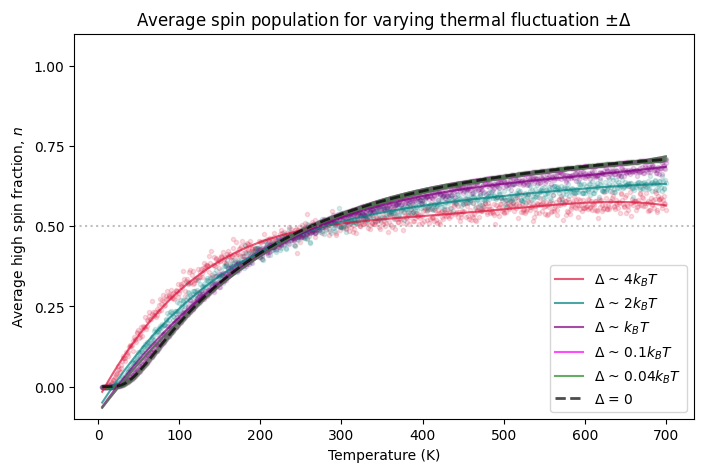

In [28]:
temps2 = np.linspace(5,700, 800)
n300_mags = {}
n_mags = {}
n_mags_ = []
yticks = [0, 0.25, 0.5, 0.75, 1.0]
num_samples = 500
samples = np.linspace(0,num_samples, num_samples)
mags = [1/4, 1/2, 1, 10, 25]#[1/4, 1/3, 1/2, 1, 3, 5, 8, 10, 15, 20, 25]
fig, ax1 = plt.subplots(1,1, figsize=(8,5))
for k,mag in enumerate(mags):
  mean_line = np.array([])
  for temp in temps2:
    noise_samples = thermal_energy(temp, (num_samples,6), noise_factor=1)/mag
    n_noised = np.array([scpf.get_n(temp,eps=eps, noise_factor=None, LS_noise=noise[3:], HS_noise=noise[:3]).n for noise in noise_samples])
    mean_ = np.mean(n_noised)
    mean_line = np.append(mean_line,mean_)
    ax1.scatter(temp, mean_, color=colors[k], marker = '.', alpha=0.15)
  smoothed_line = savgol_filter(mean_line, 65,3)
  degree = 4
  coefs = np.polyfit(temps2, mean_line, degree)
  p = np.poly1d(coefs)
  x_fit = np.linspace(min(temps2), max(temps2), 100)
  y_fit = p(x_fit)
  if mag > 1:
    ax1.plot(x_fit, y_fit, color=colors[k],alpha=0.7, label=f'$\Delta$ ~ ${1/mag}k_BT$')
  elif mag == 1:
    ax1.plot(x_fit, y_fit, color=colors[k], alpha=0.7, label=f'$\Delta$ ~ $k_BT$')
  else:
    ax1.plot(x_fit, y_fit, color=colors[k], alpha=0.7, label=f'$\Delta$ ~ {int(1/mag)}$k_BT$')
ax1.plot(temps, reference_nhs, color='black',linestyle='dashed',  lw=2, alpha=0.7,label = '$\Delta$ = 0')
ax1.legend(loc='lower right')
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Average high spin fraction, $n$')
ax1.set_title('Average spin population for varying thermal fluctuation $\pm \Delta$')
ax1.set_ylim(-0.1,1.1)
ax1.axhline(0.5, alpha = 0.5, linestyle='dotted', color='gray')
ax1.set_yticks(yticks)
plt.show()
ax1.grid(True)

# Free energy landscape

In [29]:
# eps=[1.56108764*eps1_,.08577349*eps2_,10*eps3_]
def helmholtz(temp, eps):
  A_LS = scpf.get_E(temp, eps=eps).LS
  A_HS = scpf.get_E(temp, eps=eps).HS
  return A_LS,A_HS

def get_fth(temp,phi,eps=eps0):
  A_LS,A_HS = helmholtz(temp,eps)
  # h =*(1-phi**2)**2
  F =  (A_HS-A_LS)*(phi**2)*(3-2*phi)
  # F = A_LS + (A_HS-A_LS)*(phi**2)*(3-2*phi)
  return F # eV

def get_concavity(temp,phi,eps):
  A_LS,A_HS = helmholtz(temp,eps)
  ea = calc_ea(temp,eps=eps)
  return (6-12*phi)*(A_HS-A_LS) + ea*2*(6*(phi**2) - 6*phi+1)


def get_dw(temp,phi,eps=eps):
  ea = calc_ea(temp,eps=eps) # eV
  return ea*(phi**2)*((phi-1)**2)
  # return ea

def get_total(temp,phi,eps=eps):
  f1 = get_fth(temp, phi,eps=eps)
  f2 = get_dw(temp,phi,eps=eps)
  return f1+f2

In [30]:
phis = np.linspace(-0.2,1.2,100)
temperatures  = [20, 50, 200, 250,275,300,315,350, 400,500]

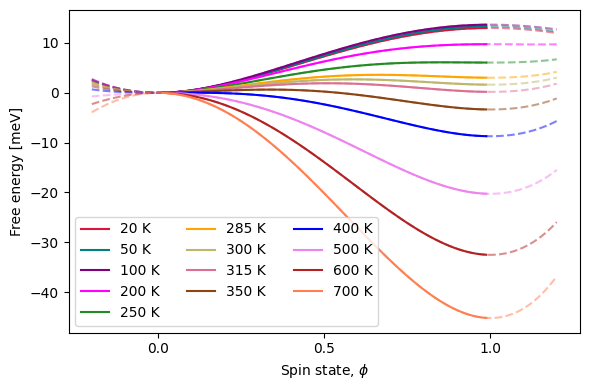

In [31]:
eps = [-30.69, -31.18, -46.04]
temperatures = [20,50,100,200,250,285,300,315,350,400,500,600,700]
fig = plt.figure(figsize=(8,4))
for z,temp in enumerate(temperatures):
  total = np.array([get_dw(temp, phi,eps=eps)+get_fth(temp,phi,eps=eps) for phi in phis])
  plt.plot(phis,1000*total, linestyle='dashed',color=colors[z], alpha = 0.5)
  plt.plot(phis[(phis<1) & (phis>0)],1000*total[(phis<1) & (phis>0)], label = f'{temp} K', color=colors[z])
plt.legend(loc='lower left', ncol=3)
plt.xticks([0,0.5,1.0])
plt.xlabel('Spin state, $\phi$')
plt.ylabel('Free energy [meV]')
# plt.title(f'[Ɛ1, Ɛ2, Ɛ3] = {eps} cm-1')
plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.show()

In [32]:
def calc_3D_total(temps,phis,eps=eps):
  X,Y = np.meshgrid(temps,phis)
  Z= []
  for i,y in enumerate(phis):
    row = []
    for j,x in enumerate(temps):
      row_ = get_fth(x,eps=eps,phi=y)+get_dw(x, y, eps=eps)
      row.append(1000*row_)
    Z.append(np.array(row))
  return X,Y,np.array(Z) # meV

In [33]:
X,Y,Z = calc_3D_total(temps2,phis,eps=eps)

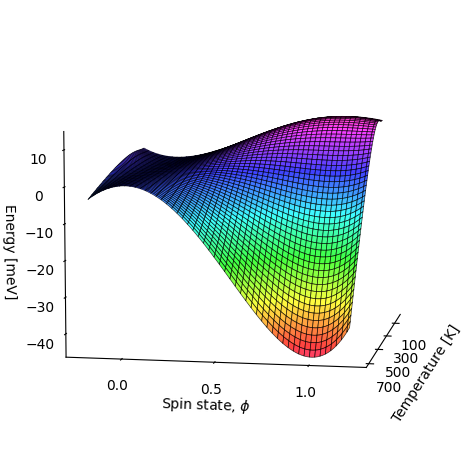

In [34]:
levels=15
from matplotlib.transforms import Bbox
fig, ax = plt.subplots(1,1, figsize=(6, 5), subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, Z, cmap='gist_rainbow',alpha=0.75, edgecolor='k',lw=0.5)
ax.set_yticks([0,0.5, 1])
ax.set_xticks([100, 300, 500, 700])
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Spin state, $\phi$')
ax.set_zlabel('Energy [meV]')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.grid(False)
ax.view_init(azim=10,elev=8) # v3
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
handles, labels = ax.get_legend_handles_labels()
bbox = Bbox.from_bounds(0, 0, fig.get_figwidth(), fig.get_figheight())
plt.show()
